# A practical guide to reproducible modeling for biochemical networks
## Methods in Molecular Biology
Developer: Veronica Porubsky <br>
Developer ORCID: 0000-0001-7216-3368 <br>
Developer GitHub Username: vporubsky <br>
Developer Email: verosky@uw.edu <br>
Model Source: Elowitz and Leibler (2000) repressilator model <br>
Model Publication DOI: 10.1038/35002125 <br>
Model BioModel ID: BIOMD0000000012 <br>
Model BioModel URL: https://www.ebi.ac.uk/biomodels/BIOMD0000000012 <br>
<br>
This notebook implements a subset of best practices to make reproducible modeling of biochemical networks accessible.

## Table of contents
* [Installations and imports](#installations-imports)
* [Data aggregation with Bioservices](#aggregate-data)
* [Importing model from the BioModels Database with Tellurium](#import--model)
* [Visualizing model network with SBGN and libsbgny](#visualize-model)
* [Annotating model in Antimony format](#annotate-model)
* [Writing simulation experiments in SED-ML using phraSED-ML](#simulate-model)
* [Estimating and storing parameter values](#estimate-parameters)
* [Verify and validate model](#test-model)
* [Package model and simulations into COMBINE archive](#package-model)


## Installations and imports  <a class="anchor" id="installations-imports"></a>

In [20]:
%%capture

# Install all relevant dependencies from requirements.txt
!pip install -r requirements.txt

# Import all relevant dependencies
from bioservices import *
import tellurium as te
import phrasedml
from libsbgnpy import render, utils
from sbmlutils.metadata.annotator import ModelAnnotator, annotate_sbml
from SBMLLint.tools.sbmllint import lint
import numpy as np
import unittest
from IPython.display import Image
import matplotlib.pyplot as plt
import tempfile
import os
import h5py
from BIOMD0000000012_study_utils import ParameterEstimation, set_radar_plot_properties
import random
from pathlib import Path
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
%matplotlib inline

## Data aggregation with Bioservices  <a class="anchor" id="data-aggregation"></a>
Description: Import K18476 query from KEGG

In [45]:
%%capture

# Set database
database = KEGG()

# Retrieve a KEGG entry
tetR_query = database.get("K18476")

# Build a dictionary to parse query
tetR_dict = database.parse(tetR_query)

In [46]:
# Show information about the query
print(tetR_dict['NAME'])
print(tetR_dict['BRITE'])

# Store collected metadata or experimental measurements
BIOMD0000000012_metadata = pd.DataFrame([[tetR_dict['NAME']],[tetR_dict['BRITE']]],
                                        ['BIOCHEMICAL SPECIES NAME','BRITE'])
BIOMD0000000012_metadata.to_excel('BIOMD0000000012_metadata.xlsx')

['TetR/AcrR family transcriptional regulator, tetracycline repressor protein']
KEGG Orthology (KO) [BR:ko00001]
             09180 Brite Hierarchies
              09182 Protein families: genetic information processing
               03000 Transcription factors
                K18476  tetR; TetR/AcrR family transcriptional regulator, tetracycline repressor protein
            Transcription factors [BR:ko03000]
             Prokaryotic type
              Helix-turn-helix
               TetR/AcrR family
                K18476  tetR; TetR/AcrR family transcriptional regulator, tetracycline repressor protein


## Importing model from the BioModels Database with Tellurium  <a class="anchor" id="import-model"></a>
Description: Use import utilities in Tellurium to load BIOMD0000000012 from the BioModels Database and simulate
 to visualize output.

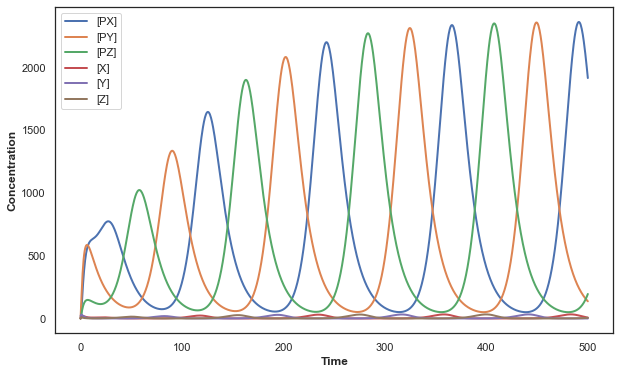

In [23]:
# Import BIOMD0000000012 from BioModels Database
repressilator_mod = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000012?filename=BIOMD0000000012_url.xml")

# Simulate model using Tellurium and libroadrunner
repressilator_mod.simulate(0, 500, 1000)
# Visualize model output
repressilator_mod.plot(figsize = (10, 6), xtitle = 'Time', ytitle = 'Concentration')
plt.show()


## Visualizing model network with SBGN and libsbgny  <a class="anchor" id="visualize-model"></a>
Description: Visualize SBGN for BIOMD0000000012. <br>

SBGN rendered: /var/folders/kl/gbh36sd919gggppy_1_wl8p80000gn/T/tmpjwrjknly.png


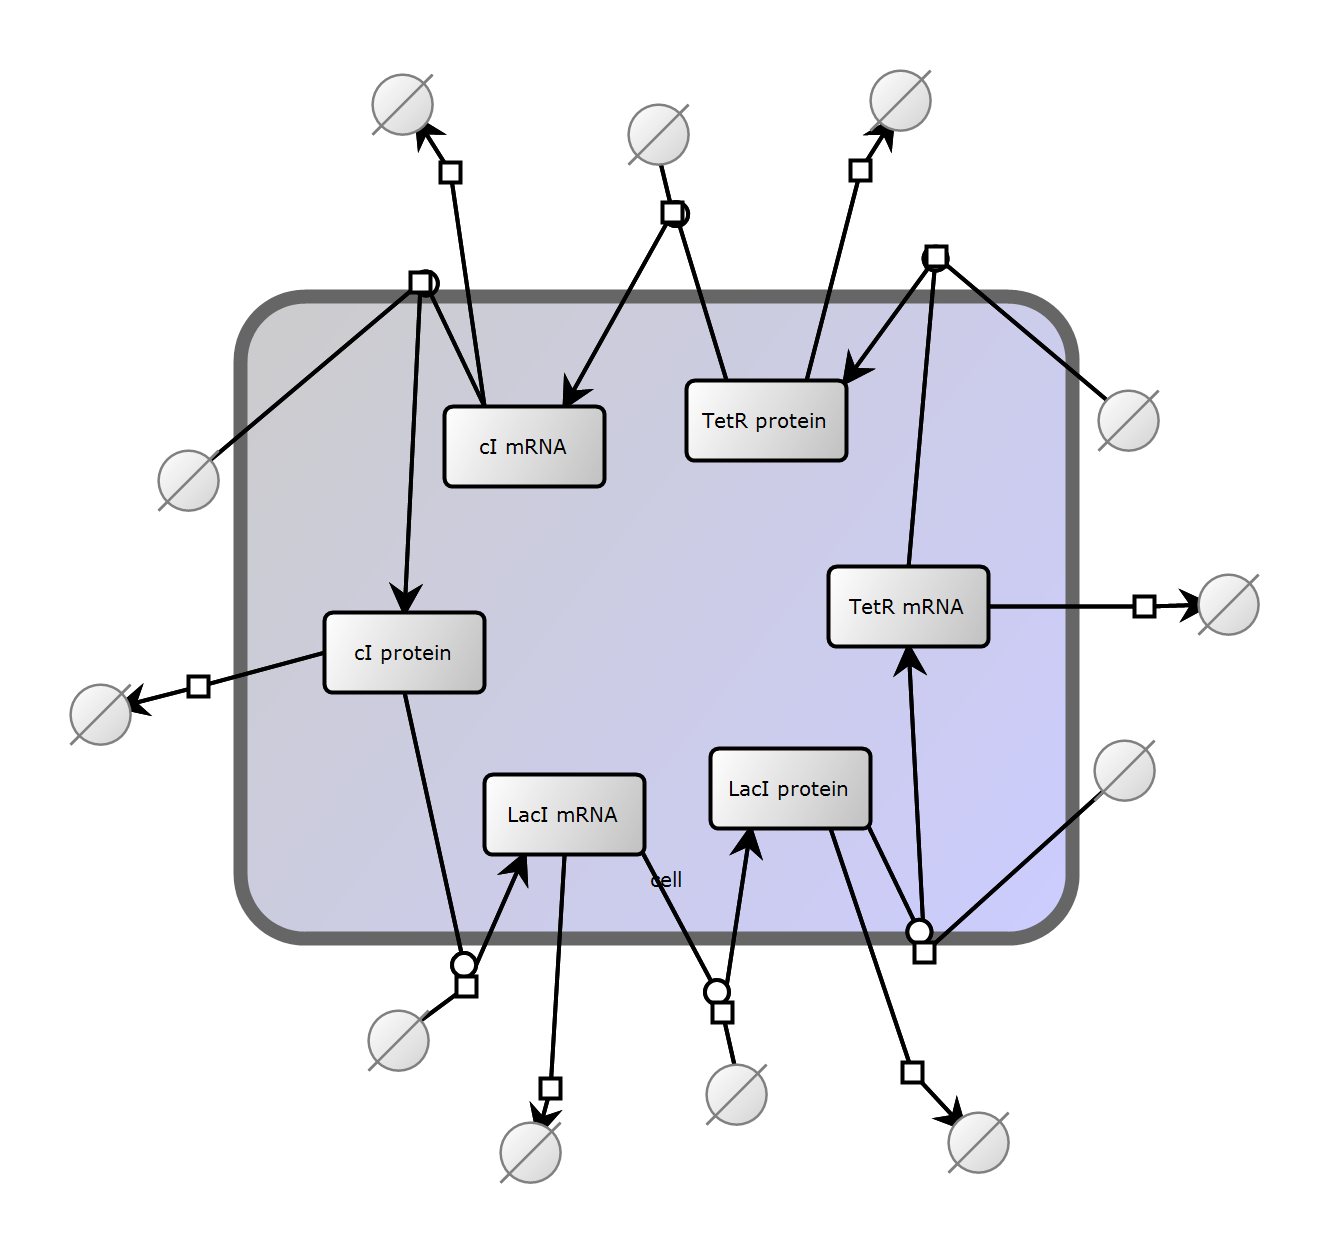

In [24]:
# SBGN network visualization.
# BIOMD0000000012.sbgn generated using CellDesigner - export SBGN-ML.
repressilator_sbgn = utils.read_from_file("BIOMD0000000012.sbgn")
repressilator_png = tempfile.NamedTemporaryFile(suffix=".png")
render.render_sbgn(repressilator_sbgn,
                   image_file=repressilator_png.name,
                   file_format="png")
Image(repressilator_png.name, width=500)

## Annotating model in Antimony format  <a class="anchor" id="annotate-model"></a>
Description: Add annotation to BIOMD0000000012 in Antimony string format. <br>

In [25]:
# Read annotations file - supplied as .xlsx table
df = ModelAnnotator.read_annotations_df('BIOMD0000000012_annotations.xlsx', file_format="xlsx")
df.style

,pattern,sbml_type,annotation_type,qualifier,resource,name
0,kd_mRNA,parameter,rdf,BQB_IS,sbo/SBO:0000356,Decay constant
1,kd_prot,parameter,rdf,BQB_IS,sbo/SBO:0000356,Decay constant
2,n,parameter,rdf,BQB_IS,sbo/SBO:0000190,Hill coefficient
3,tau_mRNA,parameter,rdf,BQB_IS,sbo/SBO:0000332,Half-life of an exponential decay
4,tau_prot,parameter,rdf,BQB_IS,sbo/SBO:0000332,Half-life of an exponential decay
5,ps_a,parameter,rdf,BQB_IS,sbo/SBO:0000186,Maximal velocity
6,ps_0,parameter,rdf,BQB_IS,sbo/SBO:0000485,Basal rate constant
7,X,parameter,rdf,BQB_IS,sbo/SBO:0000250,Ribonucleic acid
8,Y,parameter,rdf,BQB_IS,sbo/SBO:0000250,Ribonucleic acid
9,Z,parameter,rdf,BQB_IS,sbo/SBO:0000250,Ribonucleic acid


In [26]:
# Set base directory
BASE_DIR = os.getcwd()
# create SBML report without performing units checks
doc = annotate_sbml(
    source=Path(BASE_DIR + '/BIOMD0000000012.xml'),
    annotations_path=Path(BASE_DIR + '/BIOMD0000000012_annotations.xlsx'),
    filepath=Path(BASE_DIR + '/BIOMD0000000012_annotated.xml')
)

# Save annotated SBML file to working directory
annotated_sbml = doc.getSBMLDocument().toSBML()
te.saveToFile('BIOMD0000000012_annotated.xml', annotated_sbml)

## Writing simulation experiments in SED-ML using phraSED-ML  <a class="anchor" id="simulate-model"></a>
Description: Write simulation experiments for BIOMD0000000012 using phraSED-ML to generate SED-ML.<br>

In [27]:
# Load model from BioModels Database
repressilator_mod = te.loadSBMLModel(
    "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000012?filename=BIOMD0000000012_url.xml")

# Export SBML model file to current working directory
repressilator_mod.exportToSBML('BIOMD0000000012.xml')


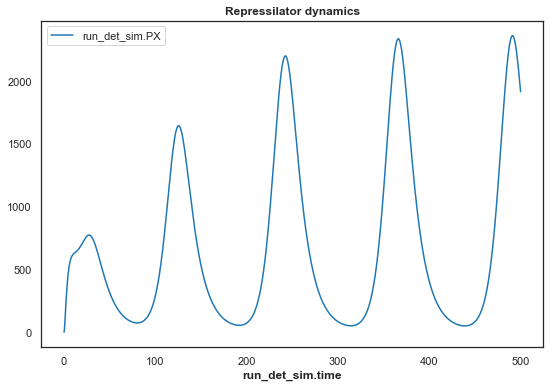

In [28]:
# Write phraSED-ML string specifying the simulation study
phrasedml_str = '''
  // Set model
  BIOMD0000000012 = model "BIOMD0000000012.xml"

  // Deterministic simulation
  det_sim = simulate uniform(0, 500, 1000)
  run_det_sim = run det_sim on BIOMD0000000012
  plot "Repressilator dynamics" run_det_sim.time vs run_det_sim.PX
'''

# Generate SED-ML string from the phraSED-ML string
repressilator_mod.resetAll()
sbml_str = repressilator_mod.getSBML()
phrasedml.setReferencedSBML("BIOMD0000000012.xml", sbml_str)
sedml_str = phrasedml.convertString(phrasedml_str)

# Save the SED-ML simulation experiment to your current working directory
te.saveToFile('BIOMD0000000012_sedml.xml', sedml_str)

# Load and run SED-ML script
te.executeSEDML('BIOMD0000000012_sedml.xml')

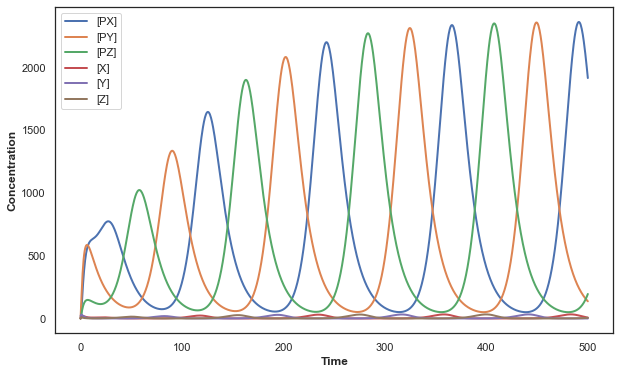

In [29]:
# Run simulation from time 0 to 500, collecting 1000 timepoints
simulation_result = repressilator_mod.simulate(0, 500, 1000)

# Plot simulation results for visualization
repressilator_mod.plot(figsize=(10, 6),
                       xtitle='Time',
                       ytitle='Concentration')
plt.show()

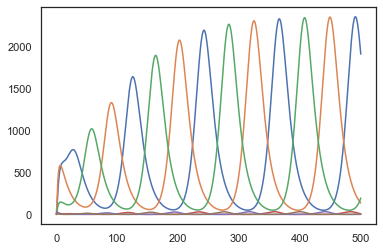

BioModels Database ID: BIOMD0000000012
Model system: repressilator
Version information: [['tellurium' '2.1.6']
 ['roadrunner' '2.0.5']
 ['antimony' '2.12.0']
 ['libsbml' '5.18.1']
 ['libsedml' '0.4.5']
 ['phrasedml' '1.1.1']]


In [30]:
# write HDF5 file for simulation results
h5f = h5py.File('BIOMD0000000012_simulation_results.h5', 'w')
dset = h5f.create_dataset('BIOMD0000000012_tellurium_simulation', data=simulation_result)
dset.attrs['Version information'] = te.getVersionInfo()
dset.attrs['BioModels Database ID'] = 'BIOMD0000000012'
dset.attrs['Model system'] = 'repressilator'
h5f.close()

# Load and plot HDF5 dataset
data_h5f = h5py.File('BIOMD0000000012_simulation_results.h5', 'r')
data = data_h5f['BIOMD0000000012_tellurium_simulation'][:]

# Visualize simulation results
plt.plot(data[:,0], data[:,1:])
plt.show()

# View dataset attributes
for key in list(data_h5f['BIOMD0000000012_tellurium_simulation'].attrs.keys()):
    print(f"{key}: {data_h5f['BIOMD0000000012_tellurium_simulation'].attrs[key]}")

data_h5f.close()

## Estimating and storing parameter values <a class="anchor" id="estimate-parameters"></a>

In [43]:
%%capture
random.seed(155)

# Set up parameter estimation routine
# Load synthetic dataset
DATA_H5F = h5py.File('BIOMD0000000012_synthetic_data.h5', 'r')
DATA = DATA_H5F['BIOMD0000000012_synthetic_dataset'][:]
DATA_H5F.close()

# Load model and specify parameters and parameter ranges for optimization
BIOMODELS_FILE_URL = 'https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000012?filename=BIOMD0000000012_url.xml'
BIOMD0000000012 = te.loadSBMLModel(BIOMODELS_FILE_URL)

# Generate parameter dictionary:
# Dictionary uses the parameter name as a key
# and the minimum search value, initial search value, and maximum search value
# are provided as a tuple value for each key
BIOMD0000000012_PARAMETERS = {
    "n": (0.0001, 1, 5),
    "tau_mRNA": (0.0001, 1, 5),
    "ps_a": (0.0001, 1, 5),
    "ps_0": (0.0001, 1, 5)
}

# Choose species for fitting with synthetic data
SPECIES_SELECTIONS = ['PX', 'PY', 'PZ']

# Initialize ParameterEstimation object
BIOMD0000000012_pe = ParameterEstimation(model=BIOMD0000000012,
                                         data=DATA,
                                         params=BIOMD0000000012_PARAMETERS,
                                         species_selections=SPECIES_SELECTIONS)

# Minimize the objective using parameter ranges and lmfit
BIOMD0000000012_optimized_params = BIOMD0000000012_pe.optimize_parameters()


Parameters([('n', <Parameter 'n', value=3.5051908592437986 +/- nan, bounds=[0.0001:5]>), ('tau_mRNA', <Parameter 'tau_mRNA', value=0.3232230596159277 +/- nan, bounds=[0.0001:5]>), ('ps_a', <Parameter 'ps_a', value=4.137387569432558 +/- nan, bounds=[0.0001:5]>), ('ps_0', <Parameter 'ps_0', value=0.00408103425521612 +/- nan, bounds=[0.0001:5]>)])


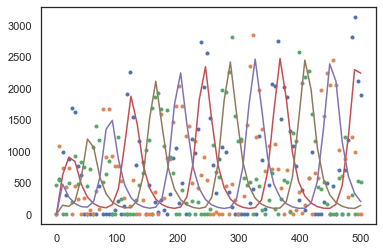

In [44]:
# Print optimized model parameter
print(BIOMD0000000012_optimized_params.params)

# Reset concentrations to initial value and reset selections
BIOMD0000000012.reset()
BIOMD0000000012.resetSelectionLists()

# Simulate model with optimized parameters
BIOMD0000000012_SIMULATION = BIOMD0000000012.simulate(0, 500, 50)

# Plot simulated data and experimental data
plt.plot(DATA[:, 0], DATA[:, 1:4], '.')
plt.plot(BIOMD0000000012_SIMULATION[:, 0], BIOMD0000000012_SIMULATION[:, 1:4])
plt.show()

In [33]:
%%capture

# %% Execute Monte Carlo
# Load synthetic dataset
data_h5f = h5py.File('BIOMD0000000012_synthetic_data.h5', 'r')
DATA = data_h5f['BIOMD0000000012_synthetic_dataset'][:]
data_h5f.close()

# Monte carlo with 10 iterations (many more iterations should be used in a real modeling study)
monte_carlo_data = BIOMD0000000012_pe.run_monte_carlo(num_itr=10)

# Save new Monte Carlo results as hdf5
monte_carlo_data.to_hdf('BIOMD0000000012_parameter_sets_.h5', key='BIOMD0000000012_estimated_parameters', mode='w')

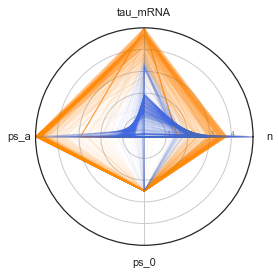

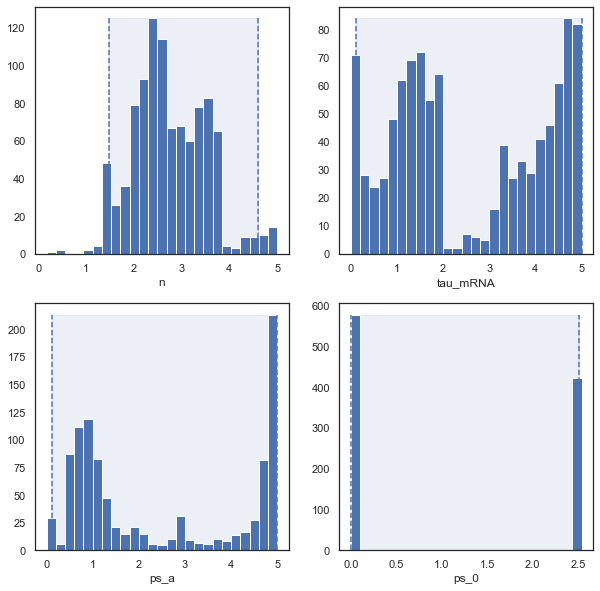

In [34]:
# Create Radar plot for two sets of parameters -------------------------------------------------------------------------
# Reload Monte Carlo dataset optimized with 100 parameter sets
monte_carlo_data = pd.read_hdf('BIOMD0000000012_monte_carlo_data.h5', 'BIOMD0000000012_estimated_parameters')

# Create Radar plot of all parameter sets, use kmeans clustering to identify "families" of parameter values ------------
mat = monte_carlo_data.values
km = KMeans(n_clusters=2)
km.fit(mat)
labels = km.labels_

ax, angles = set_radar_plot_properties(monte_carlo_data)
for i in range(np.shape(monte_carlo_data)[0]):
    values = monte_carlo_data.loc[i].values.flatten().tolist()
    values += values[:1]
    if labels[i] == 1:
        ax.plot(angles, values, linewidth=1, color='royalblue', alpha=0.05, linestyle='solid')
    else:
        ax.plot(angles, values, linewidth=1, color='darkorange', alpha=0.05, linestyle='solid')

plt.savefig('BIOMD0000000012_parameter_estimation_clusters.png', dpi=300)
plt.show()

# Plot confidence intervals on histograms ------------------------------------------------------------------------------
sns.set_theme()
sns.set_style('white')
DATA = monte_carlo_data.to_numpy()

# Calculate 95th percentile of data with upper and lower confidence interval
CI_lower = np.percentile(DATA, q=2.5, axis=0)
CI_upper = np.percentile(DATA, q=97.5, axis=0)

plt.rcParams.update({'font.size':14})
fig = plt.figure(figsize=(10,10))

for i in range(np.shape(DATA)[1]):
    fig.add_subplot(2,2,i+1)
    plt.xlabel(monte_carlo_data.keys()[i])
    height, bins, patches = plt.hist(DATA[:,i], bins=25)
    plt.vlines(x=[CI_lower[i], CI_upper[i]], ymin = 0, ymax=height.max(), linestyles='dashed')
    plt.fill_betweenx([0, height.max()], CI_lower[i], CI_upper[i], color='b', alpha=0.1)

plt.show()

## Verify and validate model <a class="anchor" id="test-model"></a>
Description: Example unit tests on BIOMD0000000012. <br>

In [35]:
# %% Build model-specific unit testing suite using unittest

# Implement class of helper functions for unit test suite
class BIOMD0000000012TestSuiteHelper:
    """
    Test suite helper functions for BIOMD0000000012.
    """

    def __init__(self, model):
        self.model = model

    def has_mass_balance_errors(self):
        """
        Use sbmllint to check if model has static mass-balance errors.
        Returns 'True' if there are mass-balance errors, 'False' if there are not.

        :return: bool
        """
        return lint(self.model.getCurrentAntimony(), mass_balance_check="games")

    # Check for complex eigen values
    def has_complex_eigen_vals(self):
        """
        Function to check if model (RoadRunner object instance) has complex eigenvalues.
        Returns 'True' if there is at least one complex eigenvalue, 'False' if there are only
        real-valued eigenvalues.

        :return: bool
        """
        eigen_vals = self.model.getFullEigenValues()
        return any(np.iscomplex(eigen_vals))

    # Add more helper functions to class as needed


# Implement unit test suite
class BIOMD0000000012TestSuite(unittest.TestCase):
    """
    Test suite for BIOMD0000000012.

    To set up the test suite, the user must supply an RoadRunner Object instance called MODEL.
    The model will also be simulated using Tellurium and libRoadRunner.
    """

    def setUp(self):
        self.model = MODEL
        self.data = self.model.simulate(0, 500, 50)

    def test_BIOMD0000000012_mass_balance(self):
        """
        Check if model system has mass balance errors.

        assertFalse() is a function of the unittest library which compares the value passed to the
        function to the boolean value 'False'. If there are mass-balance errors, the test value will
        return 'False' and the test will be failed. If there are no mass-balance errors, the test
        will be passed.
        """
        self.assertFalse(BIOMD0000000012TestSuiteHelper(model=self.model).has_mass_balance_errors())

    def test_BIOMD0000000012_eigen_vals(self):
        """
        Check if model system has complex eigenvalues after timecourse simulation.

        assertTrue() is a function of the unittest library which compares the value passed to the
        function to the boolean value 'True'. If there are complex eigenvalues, the test value will
        return 'True' and the test will be passed. If there are no complex eigenvalues, the test
        will be failed.
        """
        self.assertTrue(BIOMD0000000012TestSuiteHelper(model=self.model).has_complex_eigen_vals())


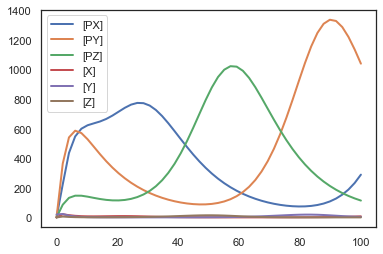

..

Model analyzed...
No error found.



----------------------------------------------------------------------
Ran 2 tests in 3.245s

OK


In [36]:
# Load model from BioModels Database and store Antimony string
BIOMD0000000012 = te.loadSBMLModel(
        "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000012?filename=BIOMD0000000012_url.xml")

# Declare the input MODEL for the test suite, a RoadRunner Object instance
MODEL = BIOMD0000000012

# Demonstrate that the error-free model has expected oscillatory dynamics
MODEL.resetAll()
MODEL.simulate(0, 100, 50)
MODEL.plot()

# Run unit test suite on the error-free model
test_suite = unittest.TestLoader().loadTestsFromTestCase(BIOMD0000000012TestSuite)
_ = unittest.TextTestRunner().run(test_suite)

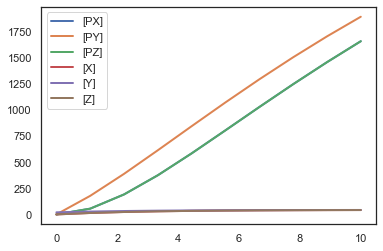

F.

Model analyzed...
No error found.



FAIL: test_BIOMD0000000012_eigen_vals (__main__.BIOMD0000000012TestSuite)
Check if model system has complex eigenvalues after timecourse simulation.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-35-9f7b1a1eb496>", line 69, in test_BIOMD0000000012_eigen_vals
    self.assertTrue(BIOMD0000000012TestSuiteHelper(model=self.model).has_complex_eigen_vals())
AssertionError: False is not true

----------------------------------------------------------------------
Ran 2 tests in 3.346s

FAILED (failures=1)


In [37]:
# Set the Hill coefficient parameter 'n' to 0 to remove oscillatory dynamics
MODEL.resetAll()
MODEL.n = 0

# Demonstrate that the model containing an error has lost oscillatory dynamics
MODEL.simulate(0, 10, 10)
MODEL.plot()

# Demonstrate that this error results in the failure of the test for complex eigenvalues
# Run unit test suite on model with error:
suite = unittest.TestLoader().loadTestsFromTestCase(BIOMD0000000012TestSuite)
_ = unittest.TextTestRunner().run(suite)



## Package model and simulations into COMBINE archive <a class="anchor" id="package-model"></a>
Description: Generate COMBINE archive using SBML and SED-ML files created for BIOMD0000000012. <br>

In [38]:
# get Antimony string of BIOMD0000000012
antimony_str = te.readFromFile('BIOMD0000000012_antimony.txt')

# create an inline OMEX string
inline_omex = '\n'.join([antimony_str, phrasedml_str])

# export to a COMBINE archive
archive_name = os.path.join(os.getcwd(), 'BIOMD0000000012.omex')
te.exportInlineOmex(inline_omex, archive_name)

